In [1]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
yf.pdr_override()
from datetime import datetime
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import data_util

In [2]:
apple_stocks=data_util.stock_data('AAPL',4,'Apple')
# plot(apple_stocks,'Apple')  

[*********************100%%**********************]  1 of 1 completed


In [3]:
stocks = apple_stocks[['Close']].copy()

### We First do the Augmented Dickey Fuller Test to check the Stationarity of the Data


In [4]:
test_Results=adfuller(stocks["Close"])
print("p-value of the Test",test_Results[1])

p-value of the Test 0.10946839709448608


#### Since the p-value is large , we conclude that the data is not stationary. We take the difference and again do the ADS test .

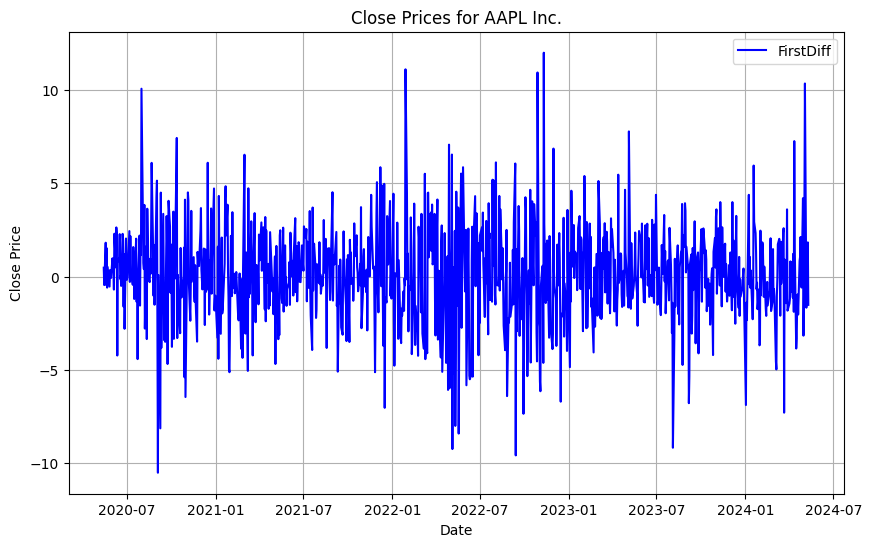

In [5]:
stocks['FirstDiff'] = stocks['Close'].diff().dropna()
plt.figure(figsize=(10, 6))
plt.plot(stocks.index, stocks['FirstDiff'], color='blue', label='FirstDiff')
plt.title(f'Close Prices for {"AAPL"} Inc.')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()  
plt.grid(True)
plt.show()

In [6]:
test_Results=adfuller(stocks["FirstDiff"][1:])#first entry will be Nan
print("p-value of the Test",test_Results[1])

p-value of the Test 0.0


#### On taking the first difference we get the p-value as low as 0.00 , thus we conclude the first diffeernce data is stationary . This can be further be confirmed by using ndiff function in pmdarima library.

In [7]:
from pmdarima.arima.utils import ndiffs

d = ndiffs(stocks["Close"])

print("No. of differences needed:", d)

No. of differences needed: 1


#### Now we plot AutoCorrelation Function(ACF) and Partial AutoCorrelation Function(PACF) to determing the order of ARIMA model.

<BarContainer object of 30 artists>

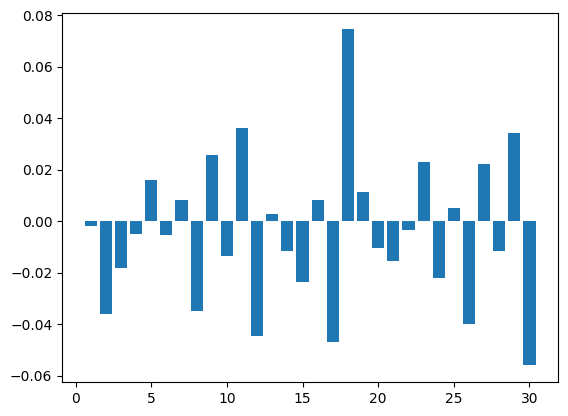

In [8]:
acf_vals = acf(stocks['FirstDiff'][1:])
plt.bar(range(1,acf_vals.shape[0]), acf_vals[1:acf_vals.shape[0]])
# acf_vals.shape

<BarContainer object of 30 artists>

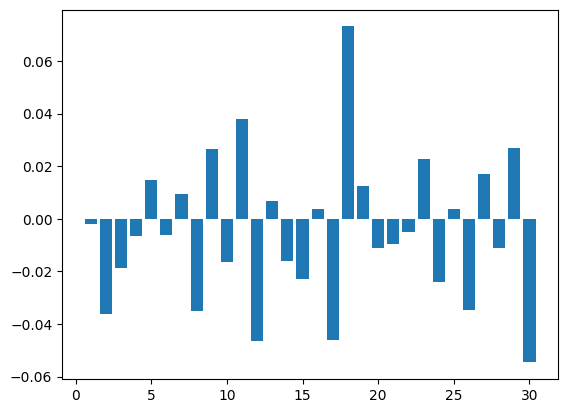

In [9]:
pacf_vals = pacf(stocks['FirstDiff'][1:])
plt.bar(range(1,pacf_vals.shape[0]), pacf_vals[1:pacf_vals.shape[0]])

In [10]:
train=pd.DataFrame(stocks['Close'][0:int(len(stocks)*0.70)])
test=pd.DataFrame(stocks['Close'][int(len(stocks)*0.70):])


In [11]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(train, order=(2,1,2))
# model = ARIMA(stocks['FirstDiff'][1:], order=(2,0,2))

model_fit = model.fit()
print(model_fit.summary())

c:\Users\baljyot\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\baljyot\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\baljyot\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\baljyot\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  704
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1717.744
Date:                Mon, 13 May 2024   AIC                           3445.488
Time:                        04:38:48   BIC                           3468.265
Sample:                             0   HQIC                          3454.291
                                - 704                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9796      0.007    134.124      0.000       0.965       0.994
ar.L2         -0.9983      0.007   -138.560      0.000      -1.012      -0.984
ma.L1         -0.9856      0.016    -59.842      0.0

c:\Users\baljyot\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(array([0.00372668, 0.00496891, 0.03726682, 0.07391253, 0.17453295,
        0.09813596, 0.03478237, 0.00683225, 0.00062111, 0.00186334]),
 array([-10.31308785,  -8.02288699,  -5.73268613,  -3.44248527,
         -1.15228441,   1.13791645,   3.42811731,   5.71831816,
          8.00851902,  10.29871988,  12.58892074]),
 <BarContainer object of 10 artists>)

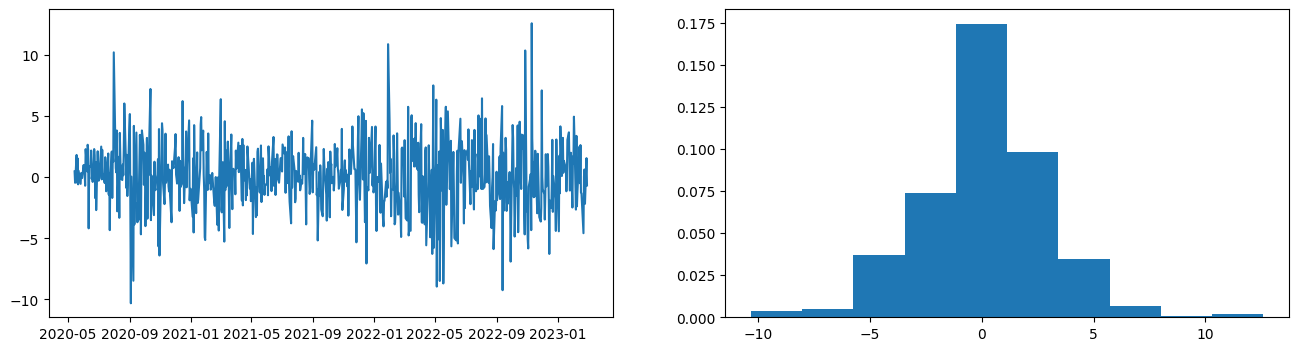

In [12]:
residuals = pd.DataFrame(model_fit.resid[1:])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(residuals)

ax2.hist(residuals, density=True)

In [13]:
predictions = model_fit.forecast(len(test))

dates = test.index.tolist()  # Convert index to list of dates
predictions = predictions.tolist()  # Convert predicted values to list

# Create a DataFrame using the lists of dates and predictions
predicted_df = pd.DataFrame({'Predicted_Value': predictions}, index=dates)

# Print the DataFrame
print(predicted_df)



            Predicted_Value
2023-03-01       147.920665
2023-03-02       148.257216
2023-03-03       148.077133
2023-03-06       147.564745
2023-03-07       147.242565
...                     ...
2024-05-06       147.952478
2024-05-07       148.148793
2024-05-08       147.939159
2024-05-09       147.537818
2024-05-10       147.353921

[302 rows x 1 columns]


c:\Users\baljyot\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\baljyot\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


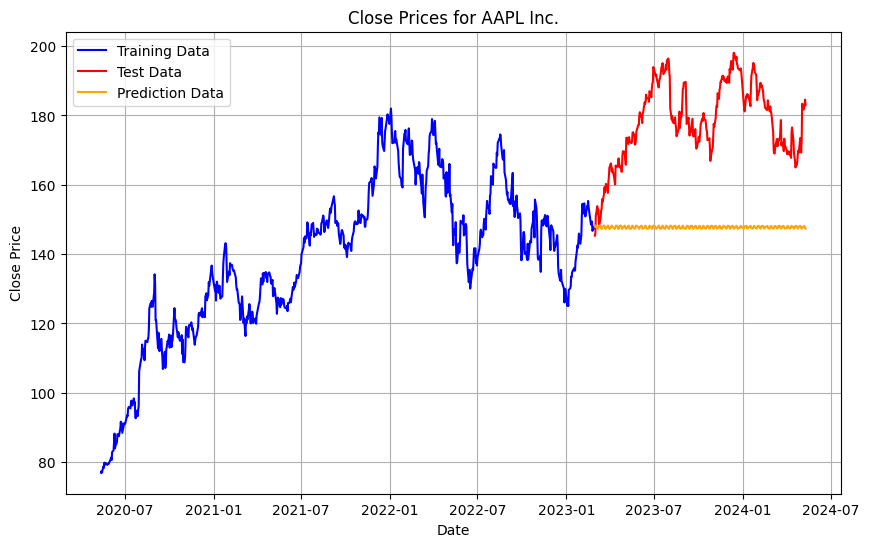

In [16]:
plt.figure(figsize=(10, 6))

# Plot training data
plt.plot(train.index, train, color='blue', label='Training Data')

# Plot test data
plt.plot(test.index, test, color='red', label='Test Data')
plt.plot(predicted_df.index, predicted_df, color='orange', label='Prediction Data')

plt.title('Close Prices for AAPL Inc.')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


## Rolling Forecast Origin

In [19]:
import warnings
warnings.filterwarnings("ignore")
rolling=int(len(stocks)*0.70)
train=pd.DataFrame(stocks['Close'][0:rolling])
test=pd.DataFrame(stocks['Close'][rolling:])
predictions_rolling=[]
for i in range(len(test)):

    model = ARIMA(train, order=(2,1,2))
    model_fit = model.fit()
    pred=model_fit.forecast()
    predictions_rolling.append(pred)
    print(float(pred),test['Close'][i])
    rolling+=1
    train=pd.DataFrame(stocks['Close'][0:rolling])
print(predictions_rolling)

147.9206650151413 145.30999755859375
145.65514112465877 145.91000366210938
145.7470271048639 151.02999877929688
150.53968937281655 153.8300018310547
153.4433090474584 151.60000610351562
151.66498067456217 152.8699951171875
153.31086649046804 150.58999633789062
150.96496661408239 148.5
148.42676938459007 150.47000122070312
150.14768211842627 152.58999633789062
152.27852446034 152.99000549316406
152.59969366921894 155.85000610351562
156.00045679719292 155.0
155.03826977928526 157.39999389648438
157.3471508763586 159.27999877929688
158.8559967027706 157.8300018310547
157.4685123980396 158.92999267578125
159.00268627869823 160.25
160.69202955011272 158.27999877929688
158.5941927451129 157.64999389648438
157.8171552404079 160.77000427246094
160.62845780819234 162.36000061035156
162.07749301195952 164.89999389648438
164.70834267945935 166.1699981689453
165.93229455889994 165.6300048828125
165.62976912677996 163.75999450683594
163.98911426314595 164.66000366210938
164.91608460463547 162.02999

In [20]:
predictions_rolling=[float(i) for i in predictions_rolling]

In [21]:

dates = test.index.tolist()

rolling_predicted_df = pd.DataFrame({'Predicted_Value': predictions_rolling}, index=dates)

# Print the DataFrame
print(rolling_predicted_df)


            Predicted_Value
2023-03-01       147.920665
2023-03-02       145.655141
2023-03-03       145.747027
2023-03-06       150.539689
2023-03-07       153.443309
...                     ...
2024-05-06       183.335903
2024-05-07       181.277939
2024-05-08       182.206147
2024-05-09       182.655747
2024-05-10       184.733961

[302 rows x 1 columns]


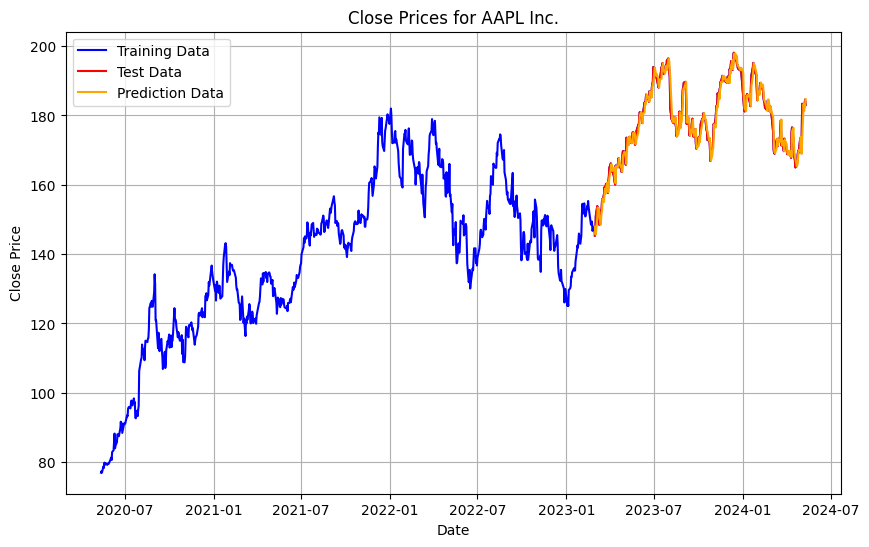

In [22]:
plt.figure(figsize=(10, 6))

# Plot training data
plt.plot(train.index, train, color='blue', label='Training Data')

# Plot test data
plt.plot(test.index, test, color='red', label='Test Data')
plt.plot(rolling_predicted_df.index, rolling_predicted_df, color='orange', label='Prediction Data')

plt.title('Close Prices for AAPL Inc.')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
from Evaluation_metrics import *
def evaluate_metrics(y_true, y_pred):
    results = {
        'Metric': ['MAPE', 'MAE', 'MSE', 'RMSE', 'R2', 'SMAPE'],
        'Value': [MAPE(y_true, y_pred), 
                  MAE(y_true, y_pred), 
                  MSE(y_true, y_pred), 
                  RMSE(y_true, y_pred), 
                  R2(y_true, y_pred), 
                  SMAPE(y_true, y_pred)]
    }
    df = pd.DataFrame(results)
    
    # Add dotted lines
    dotted_style = [dict(selector="th", props=[("border-bottom", "1px dotted #aaaaaa")]),
                    dict(selector="td", props=[("border-bottom", "1px dotted #aaaaaa")])]
    
    # Apply styling
    styled_df = (df.style
                 .set_properties(**{'text-align': 'center'})
                 .format({'Value': '{:.2f}'})  # Round values to 2 decimal places
                 .set_table_styles(dotted_style)
                 .set_caption('Evaluation Metrics')
                 .set_table_attributes('style="border-collapse: collapse; border: none;"')
                 .set_properties(subset=['Metric'], **{'font-weight': 'bold',}))  # Bold and blue headers
    
    return styled_df

In [24]:
y_true=test["Close"].values
y_pred=rolling_predicted_df["Predicted_Value"].values
styled_df = evaluate_metrics(y_true, y_pred)
styled_df

,Metric,Value
0,MAPE,0.99
1,MAE,1.74
2,MSE,5.31
3,RMSE,2.30
4,R2,0.96
5,SMAPE,0.99
